In [1]:
from graphmodels.graphmodel import converte_to_format, GraphModel, concatenate_graph_specs
from database import select_dataset
from graphmodels.utils import get_X_y_from_data
from graphmodels.validation import score_model, plot_diagnostic
import pandas as pd
import numpy as np
from models.Hermen.model_BE2 import BE2_models

In [2]:
#fbs_data = select_dataset('foodbalancesheet')
fbs_data = select_dataset('foodbalancesheet_new')

population_data = select_dataset('population')
crops_data = select_dataset('crops')
landuse = select_dataset('landuse')
corrected_cl = pd.read_csv('outputs/cl_corr.csv')

In [3]:
model_df = pd.concat([fbs_data, population_data, crops_data],).dropna(subset=['Variable'])
model_df = model_df[~model_df.Variable.isin(['Domestic supply quantity'])]

In [4]:
from graphmodels.utils import df_to_data_dict

def get_X_y_from_data(model, data_dict):
    '''TO CLEAN UP'''
    X = {key: data_dict[key] for key in model.inputs_() + model.parameters_()}
    y = {key: data_dict[key] for key in model.variables_() + model.outputs_() if key in data_dict}
    return X, y


def df_to_dict(df):
    X = {}
    for code in df.columns:
        X[code] = df[code].fillna(0)
    return X


def fill_missing_values(df):
    return df


def df_to_data_dict(df, itemized):
    data_dict = {}

    non_item_df = df[~df.Variable.isin(itemized)].pivot(
        index=['ISO', 'Year'], columns='Variable', values='Value')
    non_item_df = fill_missing_values(non_item_df)
    
    if itemized != []:
        item_df = df[df.Variable.isin(itemized)].pivot(
            index=['ISO', 'Year', 'Item'], columns='Variable', values='Value')
        data_dict.update(df_to_dict(item_df))


    data_dict.update(df_to_dict(non_item_df))

    return data_dict


itemized = [
    'FDKCi', 'FPi', 'FIi', 'SVi', 'FEi',
    'FDi', 'SDi', 'FLOi', 'PDi', 'RDi', 'Food', 'FDKGi', 'NFDi',
    'SSRi', 'KKRi', 'TCLDi', 'CYi'
    ]

data_dict = df_to_data_dict(model_df, itemized)


data_dict.update(df_to_data_dict(landuse, itemized=[]))

data_dict['CL_baseline'] = data_dict['CL']
data_dict['IL_baseline'] = data_dict['IL']
data_dict['FL_baseline'] = data_dict['FL']
data_dict['R_rate'] = pd.Series(data=0, index=data_dict['CL_baseline'].index)


#data_dict['CL_corr_intercept'] = corrected_cl.query('name != "comp"').rename(columns={"name": 'ISO'}).set_index('ISO')['coef']
#data_dict['CL_corr_coef'] = pd.Series(data=corrected_cl.query('name == "comp"')['coef'].values[0], index=data_dict['CL_corr_intercept'].index)
data_dict['CL_corr_coef'] = 0.7

data_dict['CYi'] = data_dict['CYi'].replace(0, np.nan)

In [40]:
ISO_data_dict = {k: v.loc[['FRA', 'HUN', 'DEU', 'NLD', 'BEL', 'CHE'], [2016, 2017, 2018], :] for k, v in data_dict.items() if k not in ['CL_corr_coef']}
ISO_data_dict['CL_corr_coef'] = 1

In [41]:
from graphmodels.utils import get_X_y_from_data
X, y_true = get_X_y_from_data(BE2_models['FPi_model'], ISO_data_dict)


res = BE2_models['FPi_model'].run(X)
score_model(BE2_models['FPi_model'], X, y_true)

FPi


,r2,correlation,rmse,Variable
0,0.999884,0.999942,766.507155,FPi


In [42]:
res['FPi']

ISO  Year  Item                            
BEL  2016  Almonds, with shell                   0.000000
           Anise, badian, fennel, coriander      0.000000
           Apples                              239.200151
           Apricots                              0.000000
           Areca nuts                            0.000000
                                                  ...    
NLD  2018  Walnuts, with shell                   0.000000
           Watermelons                           0.000000
           Wheat                               985.297000
           Yams                                  0.000000
           Yautia (cocoyam)                      0.000000
Length: 3234, dtype: float64

In [43]:
ISO_data_dict['FPi']

ISO  Year  Item                            
FRA  2016  Almonds, with shell                    1.139
           Anise, badian, fennel, coriander       0.000
           Apples                              1823.123
           Apricots                             603.268
           Areca nuts                             0.000
                                                 ...   
CHE  2018  Walnuts, with shell                    2.535
           Watermelons                            0.000
           Wheat                                497.250
           Yams                                   0.000
           Yautia (cocoyam)                       0.000
Name: FPi, Length: 3234, dtype: float64

In [44]:
from graphmodels.utils import get_X_y_from_data
X, y_true = get_X_y_from_data(BE2_models['TCLDi_model'], ISO_data_dict)

res = BE2_models['TCLDi_model'].run(X)

score_model(BE2_models['TCLDi_model'], X, y_true)

FPi
TCLDi


,r2,correlation,rmse,Variable
0,0.999884,0.999942,7.665072e+02,FPi
1,0.223242,0.490290,3.824409e+11,TCLDi


In [45]:
res['CYi'].loc[:, : ,'Cereals, Total']

ISO  Year
FRA  2016    56682.0
     2017    73067.0
     2018    68291.0
HUN  2016    64866.0
     2017    58355.0
     2018    62862.0
DEU  2016    71821.0
     2017    72699.0
     2018    61789.0
NLD  2016    77769.0
     2017    87945.0
     2018    79051.0
BEL  2016    69848.0
     2017    90507.0
     2018    79831.0
CHE  2016    51546.0
     2017    68002.0
     2018    62054.0
Name: CYi, dtype: float64

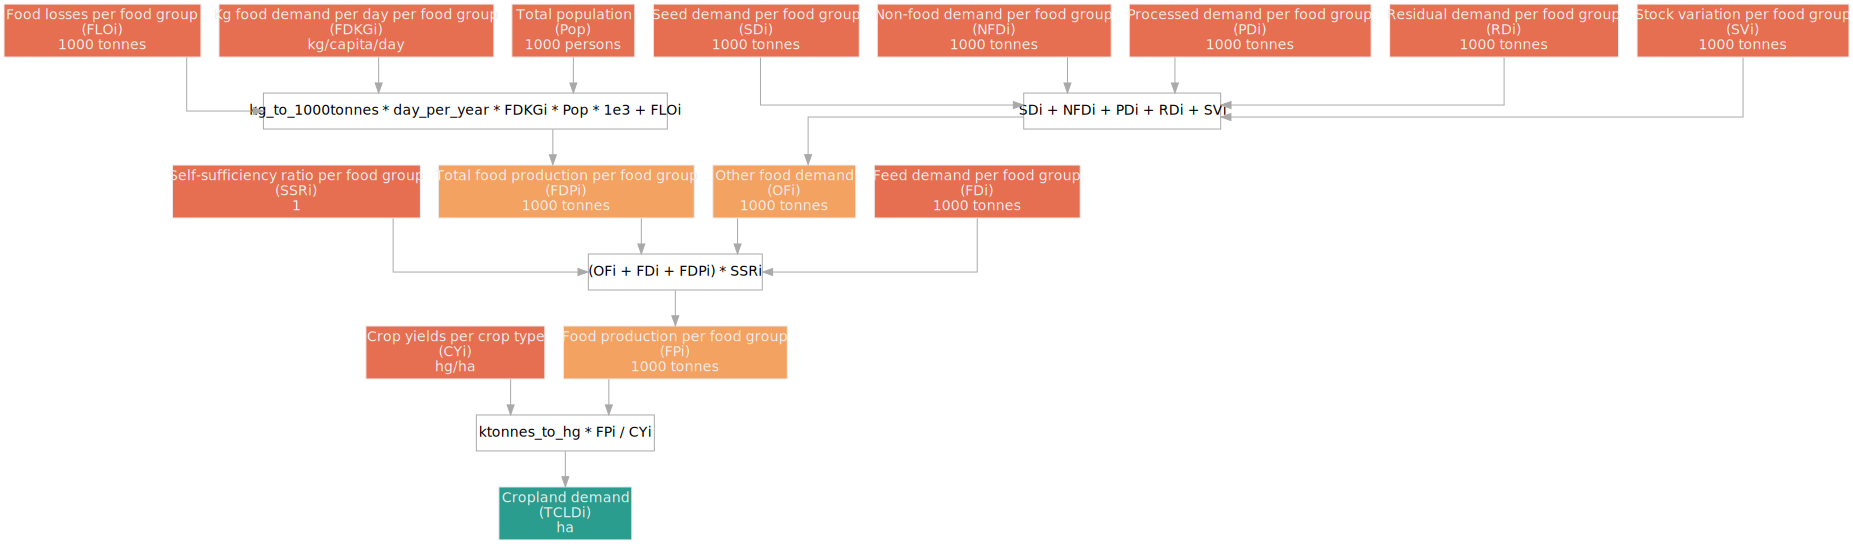

In [46]:
BE2_models['TCLDi_model'].draw()

In [47]:
plot_diagnostic(BE2_models['TCLDi_model'], X, y_true, 'TCLDi', hover_data=['Item'])

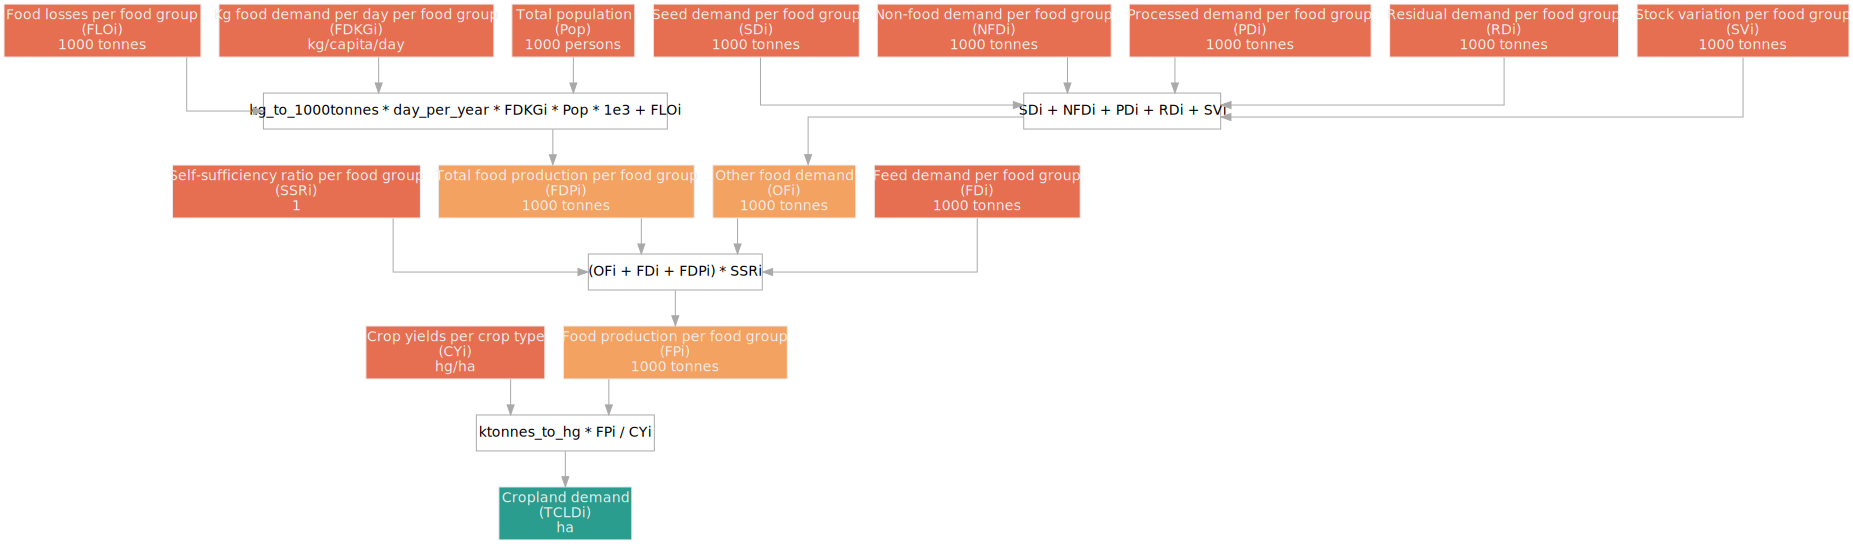

In [48]:
BE2_models['TCLDi_model'].draw()

In [49]:
X, y_true = get_X_y_from_data(BE2_models['IL_FL_model'], ISO_data_dict)

#score_model(BE2_models['IL_FL_model'], X, y_true)


In [50]:
X, y_true = get_X_y_from_data(BE2_models['BE2_model'], ISO_data_dict)
res = BE2_models['BE2_model'].run(X)
score_model(BE2_models['BE2_model'], X, y_true)

FL
IL
CL
TCLDi
FPi


,r2,correlation,rmse,Variable
0,1.000000,1.000000,0.000000e+00,FL
1,-212.514350,0.968184,7.203457e+06,IL
2,0.853996,0.998657,7.203457e+06,CL
3,0.223242,0.490290,3.824409e+11,TCLDi
4,0.999884,0.999942,7.665072e+02,FPi


In [51]:
plot_diagnostic(BE2_models['BE2_model'], X, y_true, 'CL')

In [23]:
res['CL']

ISO  Year
DEU  2018     8515.949789
FRA  2018    13486.706141
HUN  2018     3644.502016
dtype: float64

In [24]:
ISO_data_dict['CL']

ISO  Year
FRA  2018    19132.2
HUN  2018     4497.0
DEU  2018    11930.0
Name: CL, dtype: float64

In [129]:
res['TCLDi'].dropna()

ISO  Year  Item                 
DEU  2018  Apples                   3.399647e+04
           Asparagus                2.137109e+04
           Barley                   1.662002e+06
           Beans, green             3.854440e+03
           Berries nes              3.108438e+02
                                        ...     
HUN  2018  Vegetables Primary       0.000000e+00
           Vegetables, fresh nes    7.331220e+03
           Walnuts, with shell      5.401286e+03
           Watermelons              5.018530e+03
           Wheat                    1.023708e+06
Length: 209, dtype: float64

In [116]:
res['CL_baseline']

ISO  Year
FRA  2018    19132.2
Name: CL, dtype: float64

In [ ]:
plot_diagnostic(BE2_models['BE2_model'], X, y_true, 'TCLDi', hover_data=['Item'])

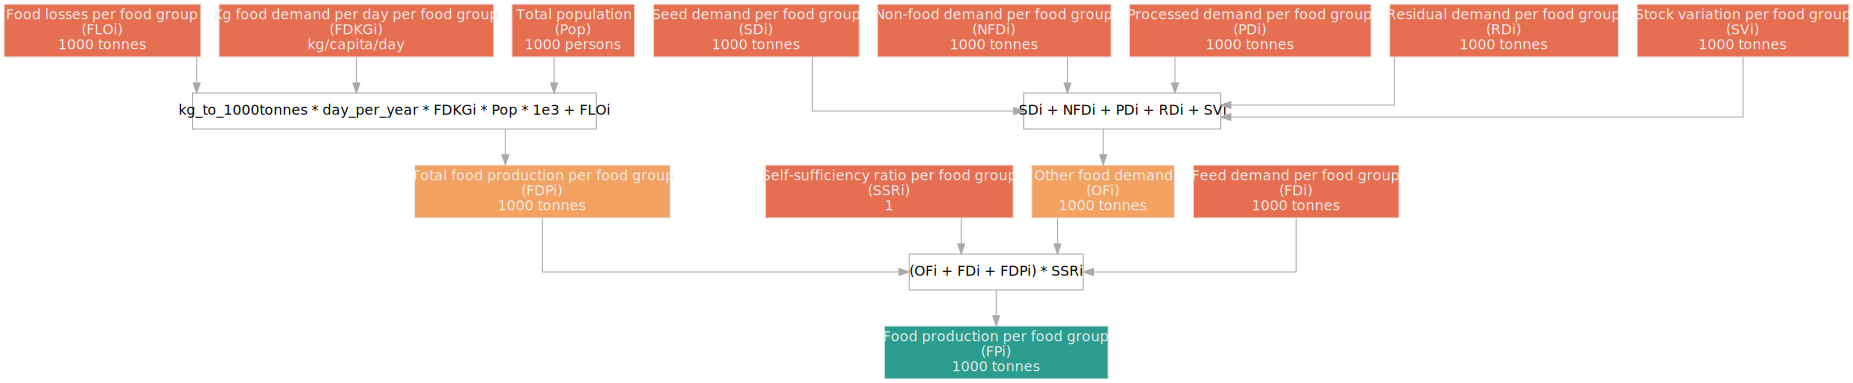

In [59]:
BE2_models['FPi_model'].draw()

In [34]:
plot_diagnostic(BE2_models['BE2_model'], X, y_true, 'CL')

/home/simon/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:47: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [ ]:
test = pd.concat([res['CL'], data_dict['CL']], axis=1)
test.columns = ['computation', 'baseline']
test = test[(test.computation != 0)].dropna()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

In [12]:
encoder =  OneHotEncoder()
one_hot_ISO = encoder.fit_transform(test.reset_index()[['ISO']]).todense()
comp = test['computation'].values.reshape(-1, 1)

X = np.concatenate([one_hot_ISO, comp], axis=1)

In [13]:
lr = LinearRegression(fit_intercept=False).fit(X, test['baseline'])
lr.score(X, test['baseline'])

0.9915974327814757

In [14]:
correction_cl = pd.DataFrame({'coef': lr.coef_, 'name': list(encoder.categories_[0]) + ['comp']})
correction_cl.to_csv('outputs/cl_corr.csv')

In [15]:
data_dict['CL_corr_coef'] = correction_cl.query('name == "comp"')['coef'].values
data_dict['CL_corr_intercept'] = correction_cl.query('name != "comp"').rename(columns={"name": 'ISO'}).set_index('ISO')['coef']

In [16]:
corrected_cl = res['CL'] * data_dict['CL_corr_coef']  +  data_dict['CL_corr_intercept']

In [17]:
test['corr'] = lr.predict(X)

In [18]:
test.loc['DEU']

,computation,baseline,corr
Year,,,
1961,11677.141656,12724.0,12262.950097
1962,11677.141656,12691.0,12262.950097
1963,11677.141656,12663.0,12262.950097
1964,11677.141656,12661.0,12262.950097
1965,11677.141656,12645.0,12262.950097
1966,11677.141656,12639.0,12262.950097
1967,11677.141656,12525.0,12262.950097
1968,11677.141656,12505.0,12262.950097
1969,11677.141656,12479.0,12262.950097


In [19]:
import plotly.express as px

px.scatter(test.loc['FRA', :, :].reset_index(), y='computation', x='baseline', hover_data=['ISO', 'Year'])

In [20]:
import plotly.express as px

px.scatter(test.reset_index(), y='computation', x='baseline', hover_data=['ISO', 'Year'])

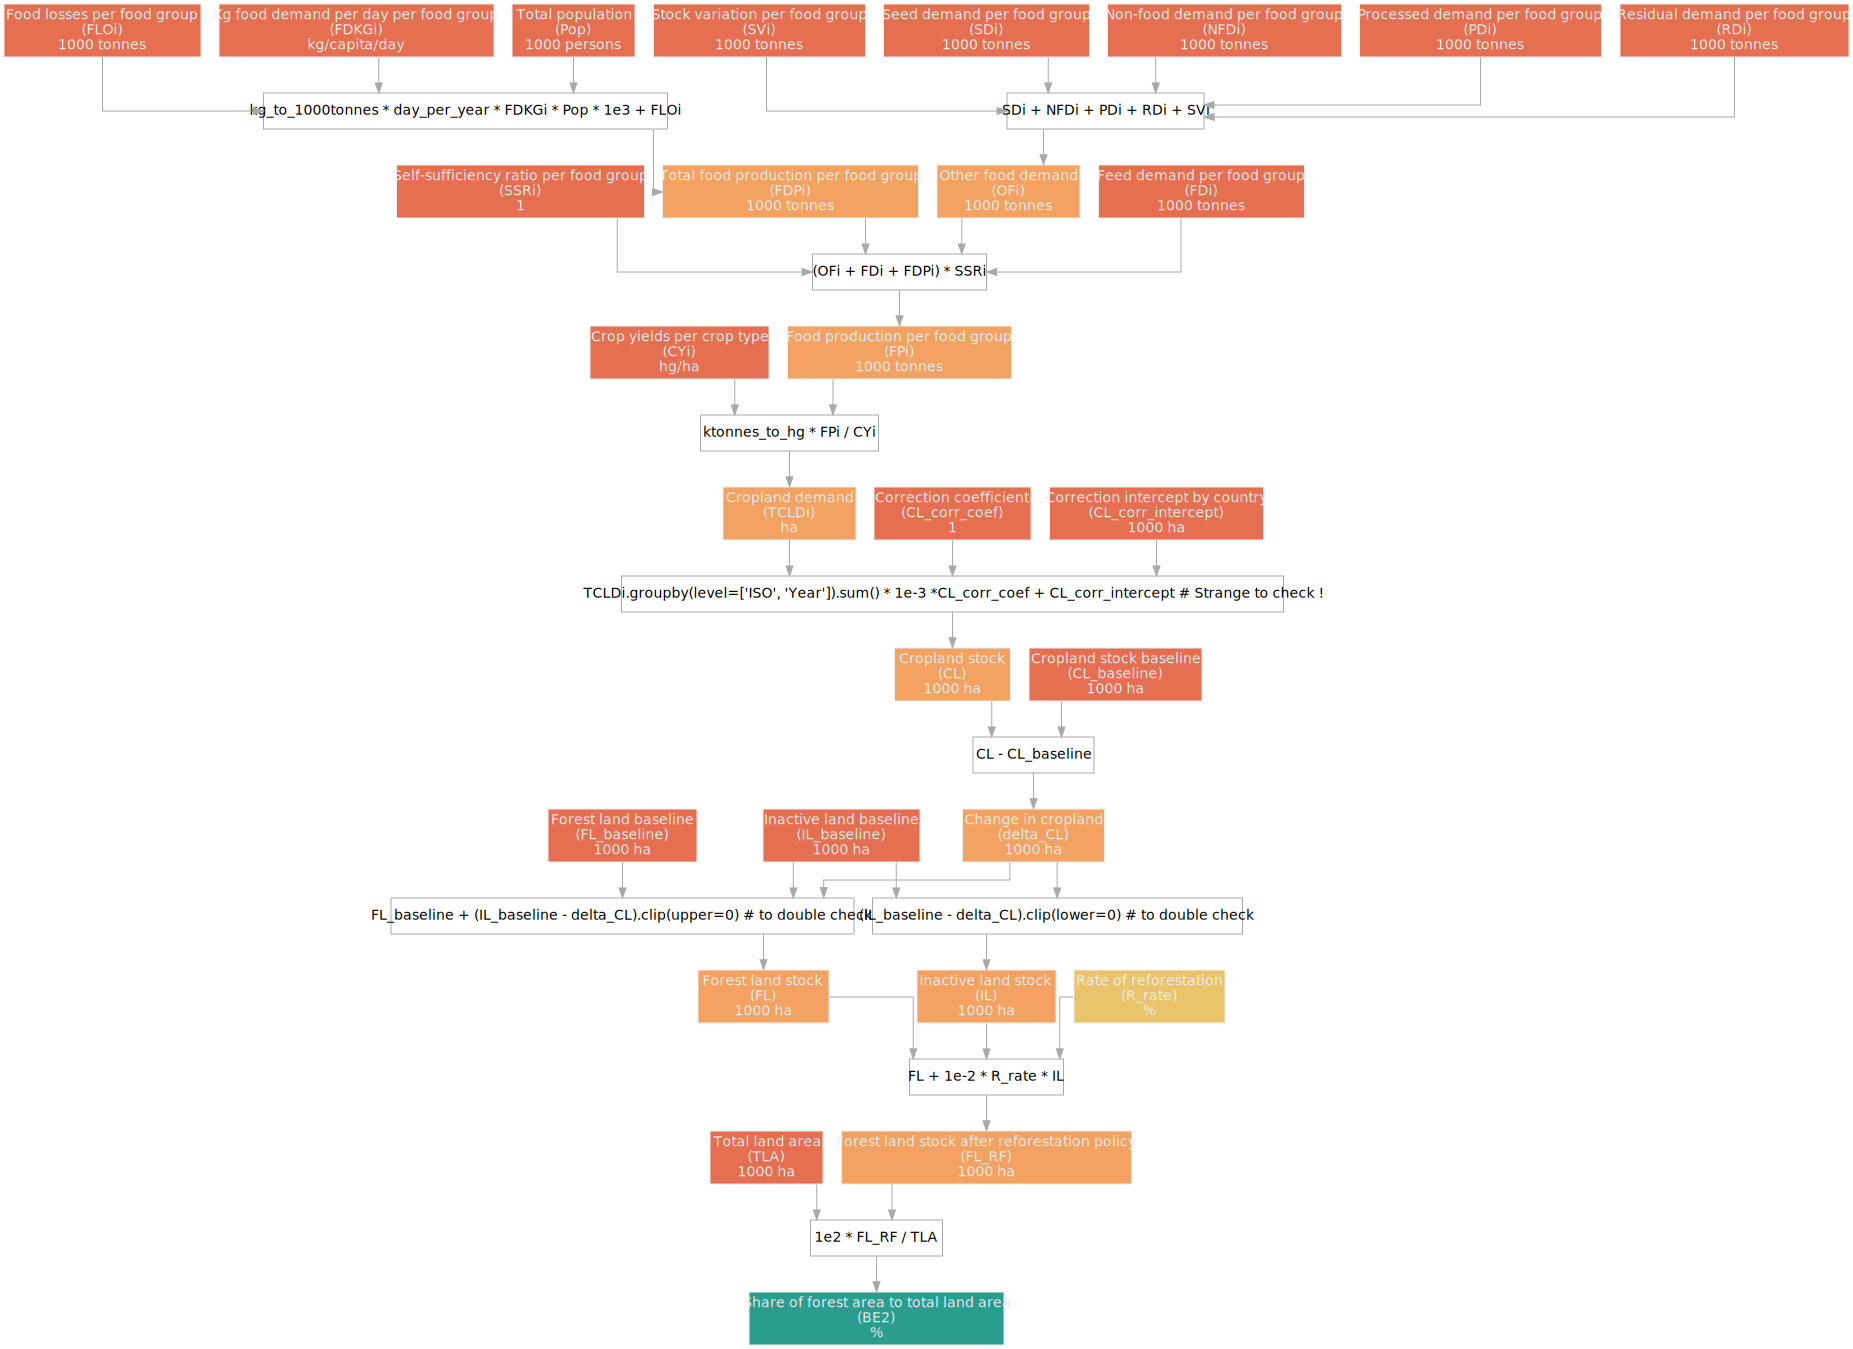

In [30]:
BE2_models['BE2_model'].draw()

# Assumptions 

- FLOi: user input, 2050 target +50 -50% baseline 
- FDKGi: user input, 1st idea a 2050 target +50 -50% baseline, interpolate in between same for everygroup. (Maybe see how to do to diet change later)
- Pop: projection
- OFi children: keep constant (maybe a regression later to have something more relevant)
- FDi: for now incomplete (FCRi in complete model maybe play with it, FCRi scenario: to check for now leave alone !). 
- SSRi : could stay constant, could be projected with pop, some increase somehow, let's see case by case (Might need some sort feedbackloop with landuse)
- CYi : user input, 2050 target ! (to look for realistic values)
- TLA: constant
- R_rate: User input, 


In [31]:
data_dict['SVi'].dropna().loc['FRA', 2014]

Item
Alcohol, Non-Food           53.0
Alcoholic Beverages        116.0
Animal fats                 31.0
Apples and products         11.0
Aquatic Animals, Others      0.0
                           ...  
Vegetables                 -30.0
Vegetables, Other          -36.0
Wheat and products        -129.0
Wine                       298.0
Yams                         0.0
Name: SVi, Length: 100, dtype: float64

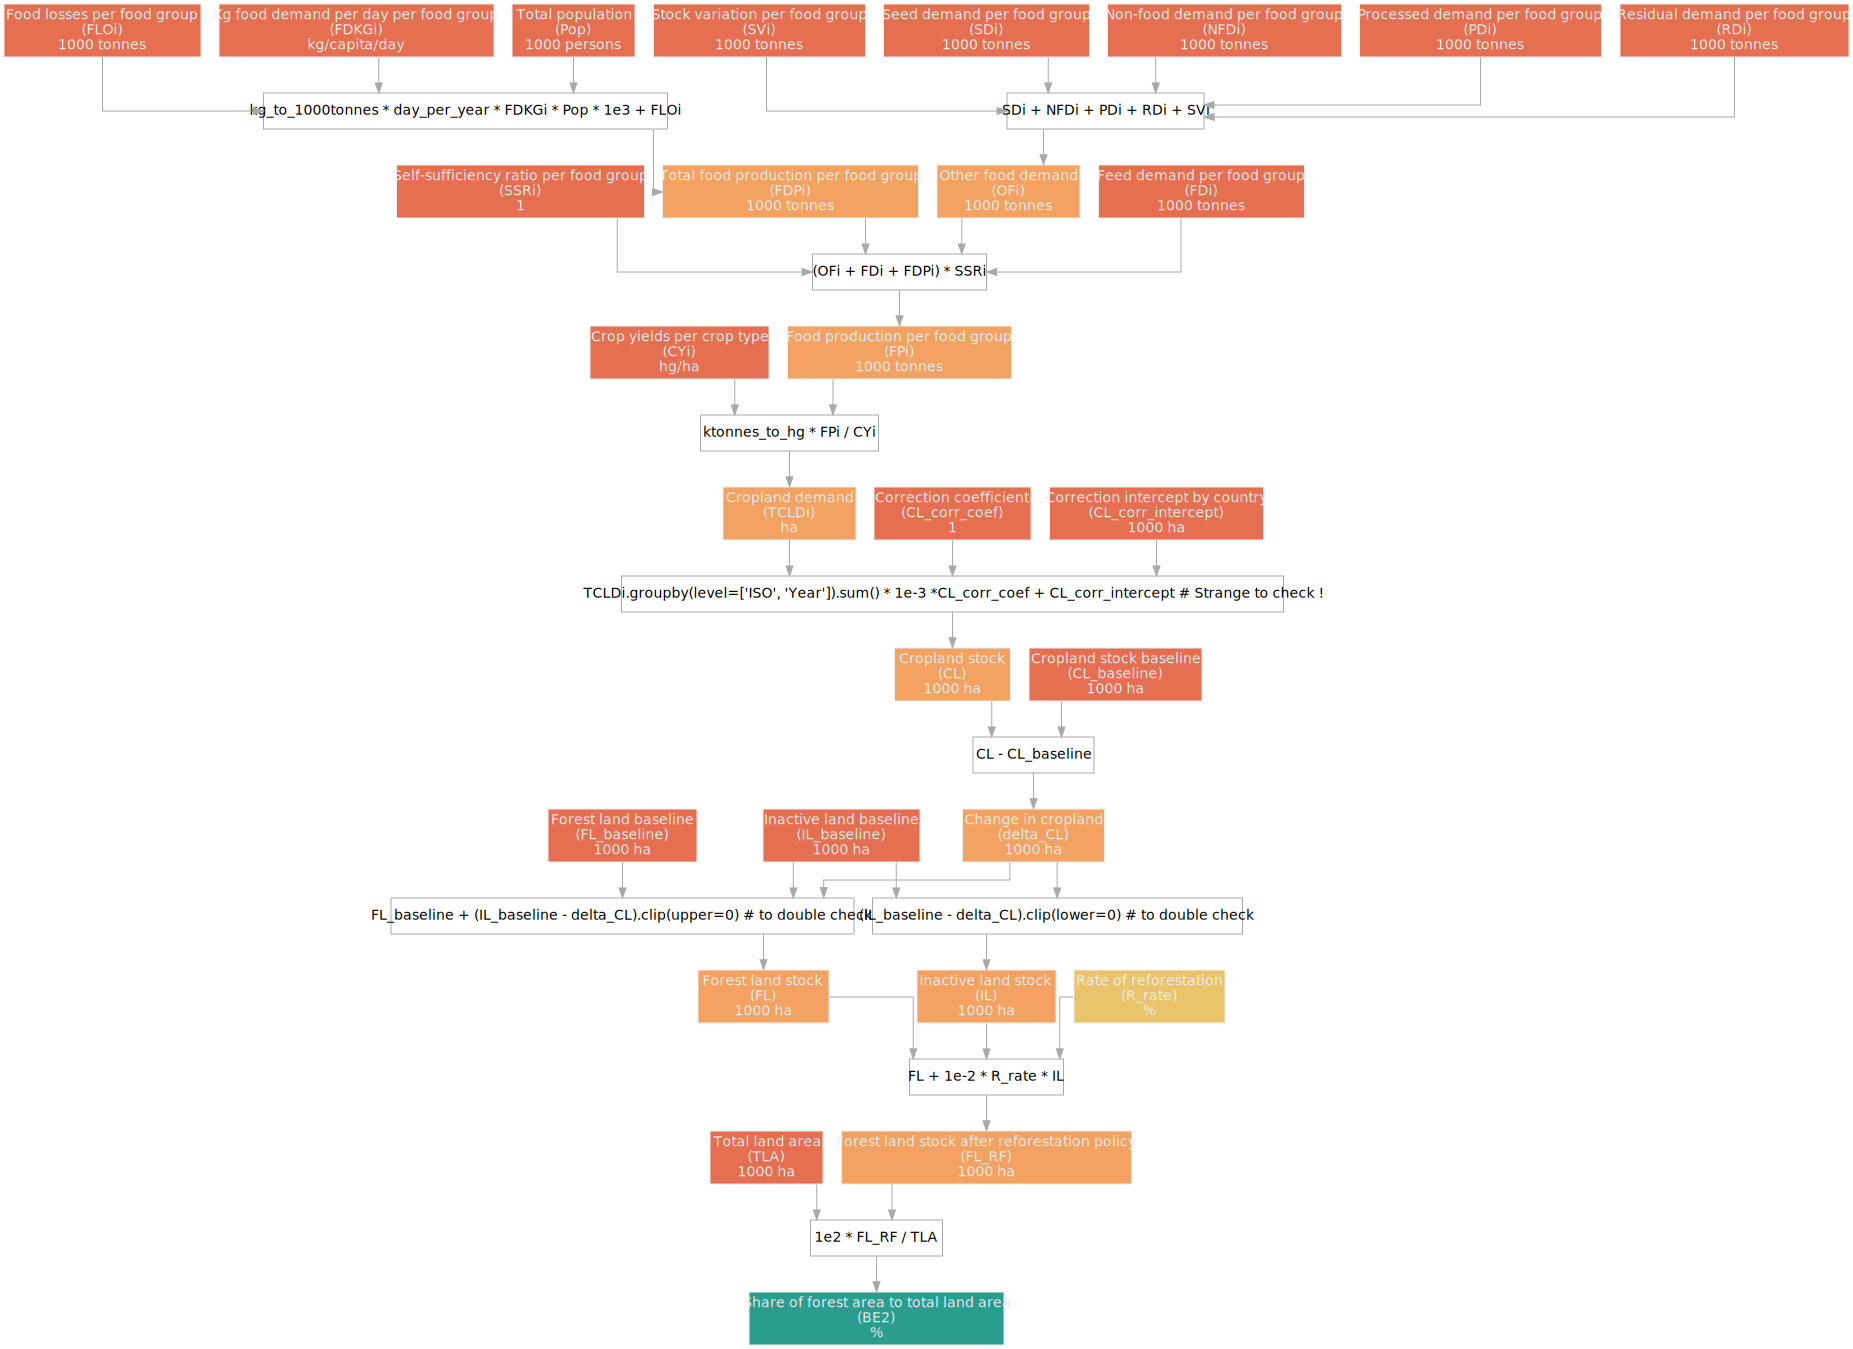

In [32]:
BE2_models['BE2_model'].draw()

In [33]:
def expand_series_non_itemized(df):
    multi_index = pd.MultiIndex.from_product([df.index.get_level_values(
        'ISO').unique(), np.arange(2000, 2051)], names=['ISO', 'Year'])
    return df.reindex(multi_index)


def expand_series_itemized(df):
    multi_index = pd.MultiIndex.from_product([df.index.get_level_values('ISO').unique(), np.arange(
        2000, 2051), df.index.get_level_values('Item').unique()], names=['ISO', 'Year', 'Item'])
    return df.reindex(multi_index)


def apply_percent_target_projection(series, percent_target=0):
    series = series.copy()
    series = expand_series_non_itemized(series)
    series.loc[:, 2050, :] = percent_target * series.loc[:, 2018, :].values
    return series.interpolate()


def apply_itemized_percent_target_projection(series, percent_target=0):
    '''To improve: Apply item wise projection'''
    series = series.copy()
    series = expand_series_itemized(series)
    series.loc[:, 2050, :] = percent_target * series.loc[:, 2018, :].values

    return series.groupby(level=['ISO', 'Item']).apply(lambda group: group.interpolate())


def apply_annual_rate_projection(series, rate=1):
    series = series.copy()
    series = expand_series_non_itemized(series)

    year = series.loc[:, 2019:].index.get_level_values(level='Year').values

    series.loc[:, 2019:] = series.loc[:, 2018].values * rate ** (year - 2019)

    return series


def apply_constant_projection(series, constant=0):
    series = series.copy()
    series = expand_series_non_itemized(series)
    series.loc[:, 2018:] = constant

    return series


def apply_itemized_ffill_projection(series):
    series = series.copy()
    series = expand_series_itemized(series)

    return series.groupby(['ISO', 'Item']).fillna(method='ffill')


def apply_ffill_projection(series):
    series = series.copy()
    series = expand_series_non_itemized(series)

    return series.groupby(['ISO']).fillna(method='ffill')


def run_BE2_scenario(data_dict, FDKGi_target=1, FLOi_target=1, CYi_target=1, R_rate=1):

    data_dict = data_dict.copy()

    projection_dict = {
        'CYi': lambda x: apply_itemized_percent_target_projection(x, CYi_target),
        'FDKGi': lambda x: apply_itemized_percent_target_projection(x, FDKGi_target),
        'FLOi': lambda x: apply_itemized_percent_target_projection(x, FLOi_target),
        'R_rate': lambda x: apply_constant_projection(x, R_rate)
    }

    for variable, function in projection_dict.items():
        data_dict[variable] = function(data_dict[variable])

    results = BE2_models['BE2_model'].run(data_dict)

    return results


def run_BE2_projection(data_dict):
    data_dict = data_dict.copy()
    
    projection_dict = {
        'FDi': lambda x: apply_itemized_ffill_projection(x),
        'SSRi': lambda x: apply_itemized_ffill_projection(x),
        'SVi': lambda x: apply_itemized_ffill_projection(x),
        'RDi': lambda x: apply_itemized_ffill_projection(x),
        'NFDi': lambda x: apply_itemized_ffill_projection(x),
        'FEi': lambda x: apply_itemized_ffill_projection(x),
        'FIi': lambda x: apply_itemized_ffill_projection(x),
        'PDi': lambda x: apply_itemized_ffill_projection(x),
        'FDi': lambda x: apply_itemized_ffill_projection(x),
        'SDi': lambda x: apply_itemized_ffill_projection(x),
        'TLA': lambda x: apply_ffill_projection(x),
        'CL_baseline': lambda x: apply_ffill_projection(x),
        'IL_baseline': lambda x: apply_ffill_projection(x),
        'FL_baseline': lambda x: apply_ffill_projection(x),
        'Pop': lambda x: apply_ffill_projection(x),
     }
     
    
    for variable, function in projection_dict.items():
        data_dict[variable] = function(data_dict[variable])

    return data_dict

In [37]:
%%time

ISO = 'FRA'
data_dict_filtered = {k: v.loc[ISO, 2000:] for k, v in data_dict.items()}
res = run_BE2_scenario(data_dict=run_BE2_projection(data_dict_filtered))


TypeError: <lambda>() missing 2 required positional arguments: 'CL_corr_coef' and 'CL_corr_intercept'

In [ ]:
data_dict['FL'].loc['FRA', 2010:]

In [ ]:
res['FL_RF'].loc['FRA', 2010:]

In [ ]:
res['FL']